# End to end Multi-Class Dog Breed Classification

## 1. Problem

Identifying the breed of a dog given an image of a dog.
When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluatopm is a file with prediction probabilities for each dog breed of test image.

## 4. Features

Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set(these iamges have labels)
* There are around 10,000+ images in the test set(these images have no labels,because we'll want to predict them).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# unzip the uploaded data into google drive
#!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision"

## Get our workspace ready

* Import tensorflow
* Import Tensorflow Hub
* Make sure we're using gpu

In [3]:
# import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)

# Check for gpu availability
print("Gpu","available (YES!)" if tf.config.list_physical_devices("GPU") else "Not available :(")

2.4.0
0.11.0
Gpu available (YES!)


##  Getting our data ready  (turning into tensors)

With all machine learning models,our data has to be in numerical format.So that's what we'll be doing first.Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [5]:
# checkout the labels of our data
import pandas as pd
labels_csv=pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     91984e95858f522d6a29150813453e7e  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


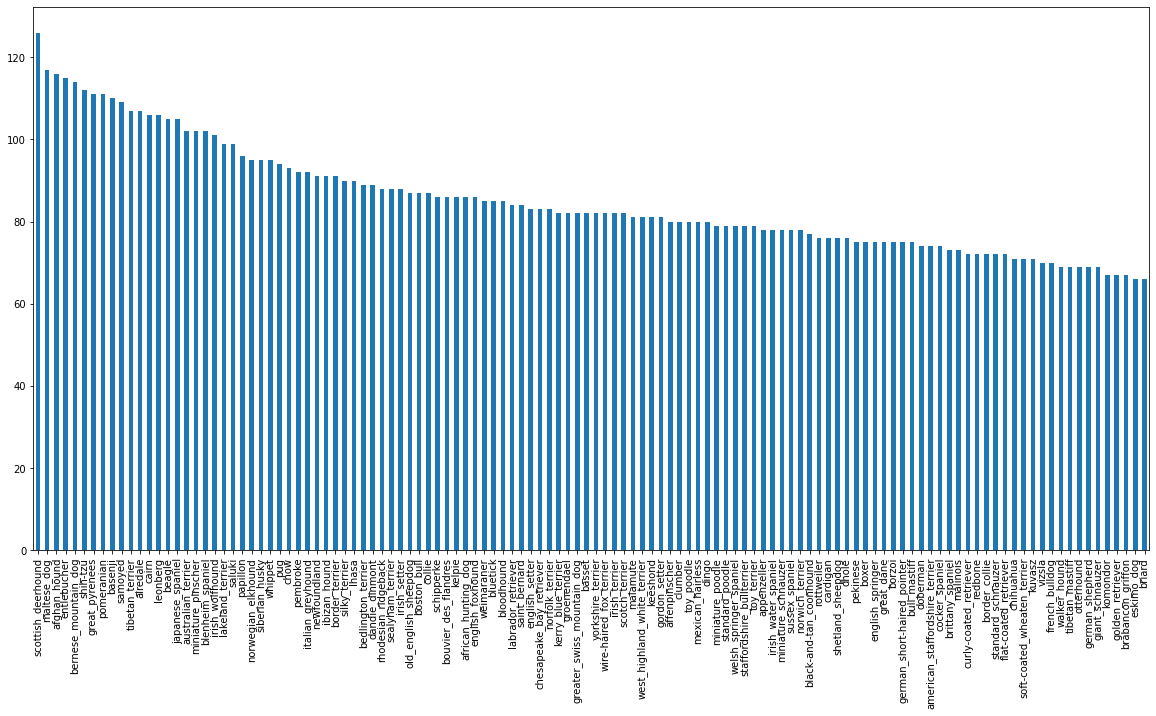

In [6]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10))

In [8]:
labels_csv['breed'].value_counts().median()

82.0

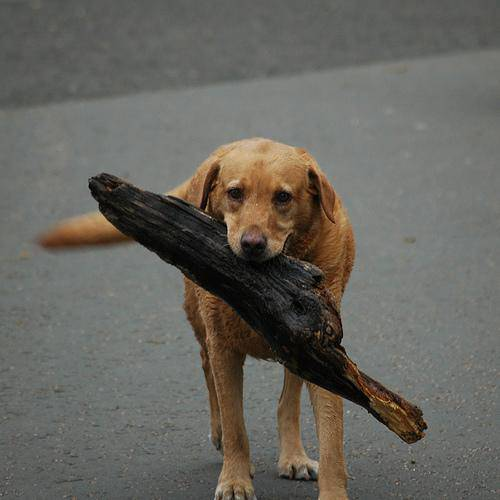

In [20]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames

In [11]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### List comprehension in python:
newlist = [expression for item in iterable if condition == True]

In [14]:
# Create pathnames from image Id's
filename=["drive/My Drive/Dog Vision/train/"+ fname +".jpg" for fname in labels_csv['id']]
filename[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [21]:
import os
os.listdir('drive/My Drive/Dog Vision/train/')[:10]

['dee5db7f0834ca1db80615a9d5fb6334.jpg',
 'e41d436e4f76b4c13a92abde03ae2721.jpg',
 'e779a2c3d07afb0056a1e33298e9eecf.jpg',
 'e23950a981b81588f00133a2c0c5cfb7.jpg',
 'e316925eb1cf7cdeb1ffaab7424e231d.jpg',
 'e60889840323eb4be2ff9498c79c1409.jpg',
 'dbf58e6de2a26b9f6f26c1c8723af964.jpg',
 'db906850433ed033317baa34a0905fb4.jpg',
 'e82a61cd6a3285ab9bba11fc8d752fa9.jpg',
 'de477e14f0f55d3b3f591f137d13a698.jpg']

In [23]:
# Check whether number of filenames matches number of actual image files

if len(os.listdir('drive/My Drive/Dog Vision/train/')) == len(filename):
  print("Filenames match actual amount of files!!! Proceed")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files!!! Proceed


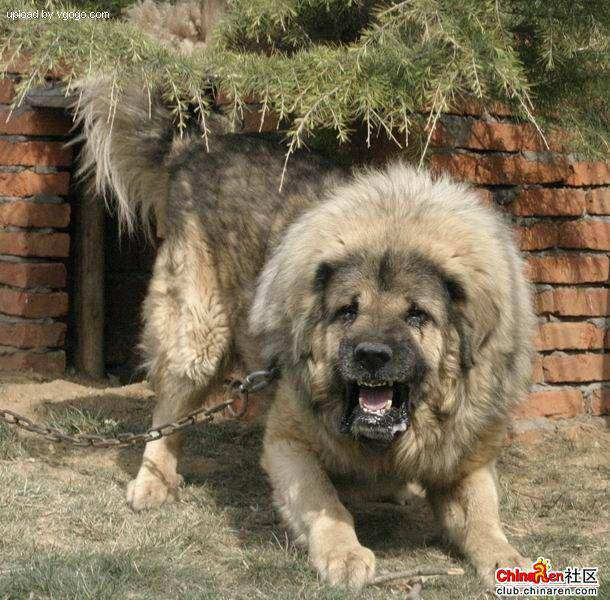

In [24]:
# One more check
Image(filename[9000])

In [25]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in alist,let's prepare our labels

In [52]:
import numpy as np
labels=labels_csv['breed'].to_numpy()
# labels=np.array(labels) # does same thing as before
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [27]:
len(labels)

10222

In [29]:
# See if number of labels matches the number of filenames
if len(labels)==len(filename):
  print("number of labels matches number of filenames!")
else:
  print('Number of labels does not match no. of filenames, check data directories!')


number of labels matches number of filenames!


In [43]:
# Find the unique label values
unique_breeds=labels_csv['breed'].unique()
print(unique_breeds)
len(unique_breeds)

['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 'cairn' 'affenpinscher'
 'labrador_retriever' 'ibizan_hound' 'english_setter' 'weimaraner'
 'giant_schnauzer' 'groenendael' 'dhole' 'toy_poodle' 'border_terrier'
 'tibetan_terrier' 'norwegian_elkhound' 'shih-tzu' 'irish_terrier'
 'kuvasz' 'german_shepherd' 'greater_swiss_mountain_dog' 'basset'
 'australian_terrier' 'schipperke' 'rhodesian_ridgeback' 'irish_setter'
 'appenzeller' 'bloodhound' 'samoyed' 'miniature_schnauzer'
 'brittany_spaniel' 'kelpie' 'papillon' 'border_collie' 'entlebucher'
 'collie' 'malamute' 'welsh_springer_spaniel' 'chihuahua' 'saluki' 'pug'
 'malinois' 'komondor' 'airedale' 'leonberg' 'mexican_h

120

In [44]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0]==unique_breeds

boston_bull


array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [49]:
# Turn every label into a boolean array
boolean_labels=[label==unique_breeds for label in labels]
boolean_labels[:2]

[array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False,  True, False, False, False, Fal

In [50]:
len(boolean_labels)

10222

In [53]:
# Example: Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds==labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) #index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([0]),)
0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [54]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the datset from kaggle doesn't come with a validation set,we're going to create our own

In [55]:
# Setup X & y variables
X=filename
y=boolean_labels

We're going to start off experimenting with ~1000 images and increases as needed

In [56]:
# Set number of images to use for experimenting
NUM_IMAGES=1000 # @param {type:'slider',min:1000,max:10000,step:1000}

In [57]:
# Let's split our data into train and validation sers
from sklearn.model_selection import train_test_split

# split them into training and validation of total size NUM_IMAGES
X_train,X_val,y_train,y_val=train_test_split(X[:NUM_IMAGES],
                                              y[:NUM_IMAGES],
                                              test_size=0.2,
                                              random_state=42)

len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [58]:
# Let's have a geez at the training data
X_train[:5],y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

 ### Preprocessing Images (turning images into Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image file path as input
2. Use Tensorflow to read the file and save it to varaible `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize `image` to be a shape of (224,224)
5. Return the modified `image`

Before we do,let's see what importing an image looks like.

In [59]:
# Convert an image to numpy array
from matplotlib.pyplot import imread
image=imread(filename[42])
image.shape #(height,width,color channel)

(257, 350, 3)

In [63]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [61]:
image.max(),image.min()

(255, 0)

In [62]:
# turn anything into Tensors so that it can run in the gpu
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.
1. Take an image file path as input
2. Use Tensorflow to read the file and save it to varaible `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize `image` to be a shape of (224,224)
6. Return the modified `image`

In [68]:
tensor=tf.io.read_file(filename[0])
print(tensor,'\n')
tensor=tf.image.decode_jpeg(tensor,channels=3)
print(tensor,'\n')
tf.image.convert_image_dtype(tensor,tf.float32)

tf.Tensor(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9

<tf.Tensor: shape=(375, 500, 3), dtype=float32, numpy=
array([[[0.41960788, 0.1764706 , 0.        ],
        [0.5921569 , 0.35686275, 0.16078432],
        [0.69411767, 0.4666667 , 0.27058825],
        ...,
        [0.6862745 , 0.56078434, 0.26666668],
        [0.7411765 , 0.6156863 , 0.32156864],
        [0.8352942 , 0.70980394, 0.4156863 ]],

       [[0.5882353 , 0.36078432, 0.18039216],
        [0.7019608 , 0.47450984, 0.29411766],
        [0.6431373 , 0.43137258, 0.24705884],
        ...,
        [0.654902  , 0.53333336, 0.21960786],
        [0.67058825, 0.54901963, 0.23529413],
        [0.73333335, 0.6117647 , 0.29803923]],

       [[0.5882353 , 0.3803922 , 0.21568629],
        [0.73333335, 0.53333336, 0.3647059 ],
        [0.6313726 , 0.43921572, 0.27058825],
        ...,
        [0.7803922 , 0.65882355, 0.30588236],
        [0.7568628 , 0.63529414, 0.28235295],
        [0.7843138 , 0.6627451 , 0.30980393]],

       ...,

       [[0.7372549 , 0.47450984, 0.25882354],
        [0.72

In [69]:
# Define image size
IMG_SIZE=224

# create a function for preprocessing images
def process_image(image_path,img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image=tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (R,G,B)
  image=tf.image.decode_jpeg(image,channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image=tf.image.convert_image_dtype(image,tf.float32)
  # Resize the image to our desired value(224,224)
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10000+ images in one go... they all might not fit into memory.

So that's why we do about 32(this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use Tensorflow effectively,we need our data in the form of Tensor tuples which lool like this: `(image,label)`

In [71]:
process_image(X[42]),tf.constant(y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [72]:
# Create a simple function to return a tiple (image,label)
def get_image_label(image_path,label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of(image,label).
  """
  image=process_image(image_path)
  return image,label